In [1]:
import numpy as np
import pandas as pd

We are loading previously pretrained data (run preprocess.py). This data are features generated using propythia and the target are already encoded. We can use the data directly. 

In [3]:
features = np.load("preprocessed_data/sample/propythia/features.npy")
target = pd.read_csv("preprocessed_data/sample/propythia/target.csv")['label']
features_test = np.load("preprocessed_data/sample/propythia/features_test.npy")
target_test = pd.read_csv("preprocessed_data/sample/propythia/target_test.csv")['label']
features_dev = np.load("preprocessed_data/sample/propythia/features_dev.npy")
target_dev = pd.read_csv("preprocessed_data/sample/propythia/target_dev.csv")['label']

In [4]:
features

array([[-0.55540537,  0.223404  ,  0.12045413, ..., -0.66287066,
        -0.63877204, -0.66287066],
       [-0.67657282,  0.21905535,  0.11390438, ..., -0.43402574,
        -0.49524235, -0.43402574],
       [-0.71696197,  0.57455783,  0.66939584, ..., -0.7528068 ,
        -0.66269366, -0.7528068 ],
       ...,
       [ 0.53510168, -1.79747775, -1.15869036, ...,  0.11304405,
         0.52038312,  0.11304405],
       [-0.09093014,  0.24934062,  0.1407883 , ...,  0.02302449,
         0.01494254,  0.02302449],
       [ 4.18022246,  1.99284035,  0.50618393, ...,  2.89705975,
         3.04264164,  2.89705975]])

In [5]:
features.shape

(124927, 33)

We have 33 features, we would reduce them up to 16, as I saw it in papers. For that we will use PCA. 

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
features = pca.fit_transform(features)

In [7]:
features_dev = pca.transform(features_dev)
features_test = pca.transform(features_test)

In [8]:
features.shape

(124927, 16)

For choosing the parameters, we can perform a random grid search using the validation data. However I tried, and it does not wok in our case. so we will just run the Random forest with default parameters, just to have a model. 

In [9]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 325, 550, 775, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(features_dev, target_dev)

In [11]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(features, target)

RandomForestRegressor()

In [14]:
test_pred = rf.predict(features_test)

In [20]:
test_pred = [round(pred) for pred in test_pred]

In [23]:
from sklearn.metrics import accuracy_score
print("test-acc = " + str(accuracy_score(target_test, test_pred)))

test-acc = 0.02252094972067039


In [22]:
from sklearn.metrics import classification_report
print(classification_report(target_test, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.16      0.27        77
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       106
           3       0.98      0.62      0.76        69
           4       0.09      0.01      0.03        69
           5       0.00      0.00      0.00       133
           6       0.25      0.02      0.03       107
           7       0.00      0.00      0.00        91
           8       0.00      0.00      0.00       102
           9       0.00      0.00      0.00        85
          10       0.00      0.00      0.00        72
          11       0.17      0.01      0.02        83
          12       0.00      0.00      0.00        77
          13       0.00      0.00      0.00        74
          14       0.00      0.00      0.00        87
          15       0.00      0.00      0.00        68
          16       0.42      0.12      0.19        91
          17       0.00    

d:\Programs\Conda\envs\PFAM\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programs\Conda\envs\PFAM\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programs\Conda\envs\PFAM\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results shown a poorly performing random forest. This could be besause of the training without fine tuning, or because the random forest is returning float and not integer (and may be the round was not a good idea so). The final assumption could be checked using a confusion matrix of class : 

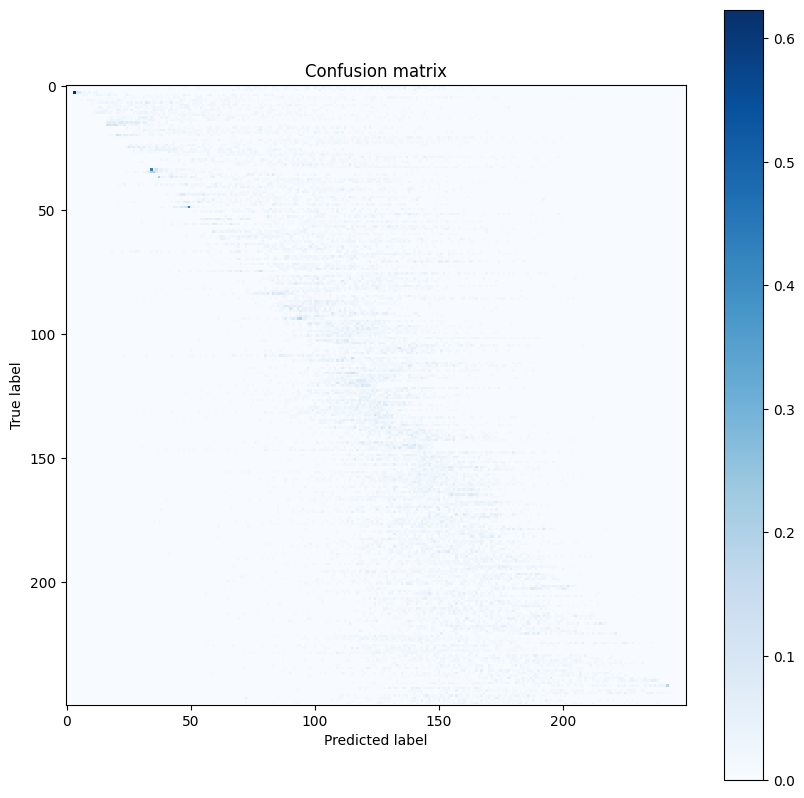

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(target_test, test_pred)

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
#tick_marks = np.arange(len(lb.classes_))
#plt.xticks(tick_marks, lb.classes_, rotation=90)
#plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


We can see correlation around the truth, but not totally. So I guess the result are close, but the training was not efficient. There is something to dig here, we defenitely could do better than that, but I am runing out of time, and I cannot perform more runs. 